In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import io
import re
import math
from tqdm.notebook import trange, tqdm

import torch
import torch.nn as nn
from torch import optim
from torch.utils.data import DataLoader
from torch.utils.data.dataset import Dataset
import torch.nn.functional as F # type: ignore
from torch.distributions import Categorical
import torchtext
from torchtext.datasets import WikiText2, EnWik9, AG_NEWS
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
import torchtext.transforms as T
from torch.hub import load_state_dict_from_url
from torchtext.data.functional import sentencepiece_tokenizer, load_sp_model

torch.backends.cuda.matmul.allow_tf32 = True

In [29]:
import pandas as pd
from sklearn.model_selection import train_test_split
import os
import re
import torch
from datasets import load_dataset

# Define batch size
batch_size = 1000

# Load the dataset
ds = load_dataset("HuggingFaceTB/cosmopedia-100k", cache_dir=r"C:\Users\ashmi\Downloads")

# Check if CUDA is available and set the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Print the first sample from the train set
print(ds['train'][0])

# Convert the dataset to a Pandas DataFrame
df = pd.DataFrame(ds['train'])

# Save the DataFrame to a CSV file
df.to_csv(r"C:\Users\ashmi\Downloads\cosmopedia_100k_train.csv", index=False)
print("Dataset successfully saved to CSV.")

# Load the saved CSV file
df = pd.read_csv(r"C:\Users\ashmi\Downloads\cosmopedia_100k_train.csv")


# Drop unnecessary columns
df = df.drop(columns=['seed_data', 'format', 'audience', 'text_token_length', 'prompt'])

# Split the data into train and test sets
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

# Function to clean the text in the DataFrame
def clean_text(df):
    df['text'] = df['text'].apply(lambda text: re.sub(r'\|\n|;', ' ', text.replace('"', ' ').replace('\n', ' ')).lower())
    return df

# Clean the text in train and test sets
train_df = clean_text(train_df)
test_df = clean_text(test_df)

# Define the file paths for the train and test CSV files
data_set_root = r"C:\Users\ashmi\Downloads"
train_csv_path = os.path.join(data_set_root, "train_data.csv")
test_csv_path = os.path.join(data_set_root, "test_data.csv")

# Save the train and test sets as CSV files
train_df.to_csv(train_csv_path, index=False, encoding="utf-8")
test_df.to_csv(test_csv_path, index=False, encoding="utf-8")
print("Data successfully split and saved to train_data.csv and test_data.csv.")

# Combine the train and test CSV files into one
combined_txt_path = os.path.join(data_set_root, "combined_data.txt")
combined_df = pd.concat([train_df, test_df], ignore_index=True)

# Save the combined data as a txt file
combined_df.to_csv(combined_txt_path, index=False, sep='\t', encoding="utf-8")
print("Files successfully combined into combined_data.txt.")

{'prompt': 'Here is an extract from a webpage: "What can cause my settlement offer to be delayed?\nWhen you’ve been injured in an Austin truck accident, one of the most common questions is how long it will take for the insurance company to make an offer to settle your case. The answer depends on a variety of factors.\nThe process starts with filing an insurance claim and providing evidence that shows exactly what happened during the accident and who was at fault. This can involve gathering key Austin truck accident evidence such as:\n- Medical records\n- Photographs or video footage of the crash scene\n- Witness statements\n- Other documents related to your injuries and damages.\nOnce this information has been collected by both sides, negotiations may begin between your Austin truck accident lawyer and the insurance company on how much compensation should be offered in exchange for settling the case out of court.\nIt is important to remember that every truck accident case is unique so 

In [30]:
import pandas as pd
from sklearn.model_selection import train_test_split
import os
import re
import torch
from torch.utils.data import Dataset, DataLoader
class TextDataset(Dataset):
    def __init__(self, df):
        self.texts = df['text'].tolist()

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        return self.texts[idx]
dataset_train = TextDataset(train_df)
dataset_test = TextDataset(test_df)


shuffle = True

# Create DataLoader objects
data_loader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=shuffle)
data_loader_test = DataLoader(dataset_test, batch_size=batch_size, shuffle=False)

print("DataLoader objects created successfully.")

DataLoader objects created successfully.


In [31]:
device = torch.device("cuda")

In [32]:
import os
import sentencepiece as spm

options = dict(
  # input spec
  input=r"C:\Users\ashmi\Downloads/combined_data.txt",  # specify the correct path
  input_format="text",
  # output spec
  model_prefix="tok400",  # output filename prefix
  # algorithm spec
  model_type="bpe",  # BPE algorithm
  vocab_size=8000,  # increased from 361 to 8000 to accommodate required characters and allow for common subwords
  # normalization
  normalization_rule_name="identity",  # turn off normalization
  remove_extra_whitespaces=False,
  input_sentence_size=100059,  # max number of training sentences
  max_sentence_length=4192,  # max number of bytes per sentence
  seed_sentencepiece_size=1000000,
  shuffle_input_sentence=True,
  # rare word treatment
  character_coverage=0.9995,  # slightly reduced from 0.99995
  byte_fallback=True,
  # merge rules
  split_digits=True,
  split_by_unicode_script=True,
  split_by_whitespace=True,
  split_by_number=True,
  max_sentencepiece_length=16,
  add_dummy_prefix=True,
  allow_whitespace_only_pieces=True,
  # special tokens
  unk_id=0,  # the UNK token MUST exist
  bos_id=1,  # the others are optional, set to -1 to turn off
  eos_id=2,
  pad_id=-1,
  # systems
  num_threads=os.cpu_count(),  # use ~all system resources
)

# Train the SentencePiece model
spm.SentencePieceTrainer.train(**options)


KeyboardInterrupt: 

In [45]:
import sentencepiece as spm

# Load the trained SentencePiece model
model_path = "tok400.model"  # Update the path if necessary
sp = spm.SentencePieceProcessor(model_file=r"tok400.model")

def tokenize_and_convert(sentence):
    # Tokenize the sentence
    tokens = sp.encode(sentence, out_type=str)  # Tokenize to string tokens
    
    # Convert tokens to IDs
    token_ids = sp.encode(sentence, out_type=int)  # Convert to integer IDs
    
    return tokens, token_ids

# Example sentence
sentence = "hi how are you"
# Tokenize and convert the sentence
tokens, token_ids = tokenize_and_convert(sentence)

# Print results
print("Original Sentence:", sentence)
print("Tokenized Sentence:", tokens)
print("Token IDs:", token_ids)


Original Sentence: hi how are you
Tokenized Sentence: ['▁hi', '▁how', '▁are', '▁you']
Token IDs: [5302, 472, 527, 352]


In [46]:
class TokenDrop(nn.Module):
    """For a batch of tokens indices, randomly replace a non-specical token with <pad>.
    
    Args:
        prob (float): probability of dropping a token
        pad_token (int): index for the <pad> token
        num_special (int): Number of special tokens, assumed to be at the start of the vocab
    """

    def __init__(self, prob=0.1, pad_token=0, num_special=4):
        self.prob = prob
        self.num_special = num_special
        self.pad_token = pad_token

    def __call__(self, sample):
        # Randomly sample a bernoulli distribution with p=prob
        # to create a mask where 1 means we will replace that token
        mask = torch.bernoulli(self.prob * torch.ones_like(sample)).long()
        
        # only replace if the token is not a special token
        can_drop = (sample >= self.num_special).long()
        mask = mask * can_drop
        
        replace_with = (self.pad_token * torch.ones_like(sample)).long()
        
        sample_out = (1 - mask) * sample + mask * replace_with
        
        return sample_out

In [47]:
device = torch.device("cuda")

In [48]:
import torch
from torchtext.transforms import SentencePieceTokenizer, ToTensor
from torchtext.data.utils import get_tokenizer
import sentencepiece as spm

# Load SentencePiece model
sp = spm.SentencePieceProcessor(model_file="tok400.model")

# Tokenization and conversion to IDs
def tokenize_and_convert(text):
    return sp.encode(text, out_type=int)

# Padding
def pad_sequence(token_ids, max_len=128, padding_value=0):
    if len(token_ids) < max_len:
        return token_ids + [padding_value] * (max_len - len(token_ids))
    else:
        return token_ids[:max_len]

# Custom function to apply tokenization, padding, and conversion to tensor
def transform(text, max_len=128, padding_value=0):
    token_ids = tokenize_and_convert(text)
    padded_token_ids = pad_sequence(token_ids, max_len=max_len, padding_value=padding_value)
    return torch.tensor(padded_token_ids, dtype=torch.long)


In [49]:
device = torch.device("cuda")

In [50]:
from torch.utils.data import Dataset, DataLoader

# Define the dataset class
class TextDataset(Dataset):
    def __init__(self, df, transform=None):
        self.texts = df['text'].tolist()
        self.transform = transform

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        if self.transform:
            text = self.transform(text)
        return text

# Create dataset objects with transformations
conv_dataset_train = TextDataset(train_df, transform=lambda x: transform(x, max_len=128, padding_value=0))
conv_dataset_test = TextDataset(test_df, transform=lambda x: transform(x, max_len=128, padding_value=0))


shuffle = True

# Create DataLoader objects
conv_data_loader_train = DataLoader(conv_dataset_train, batch_size=batch_size, shuffle=shuffle)
conv_data_loader_test = DataLoader(conv_dataset_test, batch_size=batch_size, shuffle=False)

print("DataLoader objects created successfully.")


DataLoader objects created successfully.


In [51]:
def inspect_dataloader(dataloader, num_batches=5):
    vocab_size = sp.GetPieceSize()
    print(f"Vocabulary size: {vocab_size}")
    
    for i, batch in enumerate(dataloader):
        if i >= num_batches:
            break
        
        print(f"\nBatch {i+1}:")
        print(f"Batch shape: {batch.shape}")
        print(f"Data type: {batch.dtype}")
        print(f"Device: {batch.device}")
        print(f"Min token ID: {batch.min().item()}")
        print(f"Max token ID: {batch.max().item()}")
        
        # Check for out-of-range token IDs
        out_of_range = (batch >= vocab_size).sum().item()
        if out_of_range > 0:
            print(f"Warning: {out_of_range} token IDs are out of vocabulary range")
        
        # Print a sample sequence from the batch
        sample_seq = batch[0].tolist()  # Convert the first sequence in the batch to a list
        print(f"Sample sequence: {sample_seq[:10]}...")  # Print first 10 tokens
        
        # Decode a sample sequence
        decoded_seq = sp.DecodeIds(sample_seq)
        print(f"Decoded sample: {decoded_seq[:50]}...")  # Print first 50 characters
        
    print("\nDataLoader inspection complete.")

# Inspect the training DataLoader
print("Inspecting Training DataLoader:")
inspect_dataloader(conv_data_loader_train)

# Inspect the test DataLoader
print("\nInspecting Test DataLoader:")
inspect_dataloader(conv_data_loader_test)

Inspecting Training DataLoader:
Vocabulary size: 8000

Batch 1:
Batch shape: torch.Size([1000, 128])
Data type: torch.int64
Device: cpu
Min token ID: 12
Max token ID: 7999
Sample sequence: [7935, 1146, 1077, 7966, 2700, 799, 289, 2395, 603, 276]...
Decoded sample:  course unit: jewelry design and manufacturing - t...

Batch 2:
Batch shape: torch.Size([1000, 128])
Data type: torch.int64
Device: cpu
Min token ID: 12
Max token ID: 7999
Sample sequence: [375, 7938, 1933, 1465, 629, 1730, 331, 3003, 5271, 7955]...
Decoded sample:  i never thought my love for niche hobbies would l...

Batch 3:
Batch shape: torch.Size([1000, 128])
Data type: torch.int64
Device: cpu
Min token ID: 12
Max token ID: 7999
Sample sequence: [7935, 2128, 982, 1153, 2627, 406, 517, 7952, 4927, 285]...
Decoded sample:  sarah had been feeling unfulfilled in her current...

Batch 4:
Batch shape: torch.Size([1000, 128])
Data type: torch.int64
Device: cpu
Min token ID: 11
Max token ID: 7999
Sample sequence: [7935, 1100, 79

In [52]:
for batch in conv_data_loader_train:
    print(type(batch))  # Should be <class 'torch.Tensor'>
    print(batch.shape)  # Check the shape of the tensor
    break  # Remove this if you want to inspect all batches


<class 'torch.Tensor'>
torch.Size([1000, 128])


In [53]:
device = torch.device("cuda")

In [54]:
# Define the hyperparameters
# Learning rate for the optimizer

# Batch size for data loaders
batch_size = 256

# Maximum sequence length for text inputs
max_len = 64

In [16]:
device = torch.device("cuda")

In [55]:
# Sinusoidal positional embeddings
class SinusoidalPosEmb(nn.Module):
    """
    Sinusoidal positional embeddings module.
    """

    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, x):
        # Calculate sinusoidal positional embeddings
        device = x.device
        half_dim = self.dim // 2
        emb = math.log(10000) / (half_dim - 1)
        emb = torch.exp(torch.arange(half_dim, device=device) * -emb)
        emb = x[:, None] * emb[None, :]
        emb = torch.cat((emb.sin(), emb.cos()), dim=-1)
        return emb

    
# Transformer block with Attention and causal masking
class TransformerBlock(nn.Module):
    """
    Transformer block with self-attention and causal masking.
    """

    def __init__(self, hidden_size=128, num_heads=4):
        super(TransformerBlock, self).__init__()

        # Layer normalization for input
        self.norm1 = nn.LayerNorm(hidden_size)

        # Multi-head self-attention mechanism
        self.multihead_attn = nn.MultiheadAttention(hidden_size, 
                                                    num_heads=num_heads, 
                                                    batch_first=True,
                                                    dropout=0.1)

        # Layer normalization for attention output
        self.norm2 = nn.LayerNorm(hidden_size)

        # Feedforward neural network
        self.mlp = nn.Sequential(
            nn.Linear(hidden_size, hidden_size * 4),
            nn.ELU(),
            nn.Linear(hidden_size * 4, hidden_size)
        )

    def forward(self, x, padding_mask):
        # Create causal mask for Attention
        bs, l, h = x.shape
        mask = torch.triu(torch.ones(l, l, device=x.device), 1).bool()

        # Layer normalization
        norm_x = self.norm1(x)

        # Apply multi-head Attention
        x = self.multihead_attn(norm_x, norm_x, norm_x, attn_mask=mask, key_padding_mask=padding_mask)[0] + x

        # Layer normalization
        norm_x = self.norm2(x)

        # Apply feedforward neural network
        x = self.mlp(norm_x) + x
        return x

    
# "Decoder-Only" Style Transformer with Attention
class Transformer(nn.Module):
    """
    "Decoder-Only" Style Transformer with self-attention.
    """

    def __init__(self, num_emb, hidden_size=128, num_layers=3, num_heads=4):
        super(Transformer, self).__init__()

        # Token embeddings
        self.embedding = nn.Embedding(num_emb, hidden_size)

        # Positional embeddings
        self.pos_emb = SinusoidalPosEmb(hidden_size)

        # List of Transformer blocks
        self.blocks = nn.ModuleList([
            TransformerBlock(hidden_size, num_heads) for _ in range(num_layers)
        ])

        # Output layer
        self.fc_out = nn.Linear(hidden_size, num_emb)

    def forward(self, input_seq):
        # Mask for padding tokens
        input_key_mask = input_seq == 0

        # Embedding input sequence
        input_embs = self.embedding(input_seq)
        bs, l, h = input_embs.shape

        # Add positional embeddings to token embeddings
        seq_indx = torch.arange(l, device=input_seq.device)
        pos_emb = self.pos_emb(seq_indx).reshape(1, l, h).expand(bs, l, h)
        embs = input_embs + pos_emb

        # Pass through Transformer blocks
        for block in self.blocks:
            embs = block(embs, padding_mask=input_key_mask)

        # Output predictions
        return self.fc_out(embs)

In [56]:
device = torch.device("cuda")

In [57]:
num_emb=sp.GetPieceSize()

In [58]:
num_emb

8000

In [59]:
device = torch.device("cuda")

In [60]:
import torch
import torch.nn as nn
import torch.optim as optim
import sentencepiece as spm

# Load the SentencePiece model
sp = spm.SentencePieceProcessor(model_file=r"tok400.model")

# Check if GPU is available, set device accordingly
# Embedding Size
hidden_size = 256

# Number of transformer blocks
num_layers =8

# MultiheadAttention Heads
num_heads = 8

# Create model
tf_generator = Transformer(num_emb=sp.GetPieceSize(), num_layers=num_layers, 
                           hidden_size=hidden_size, num_heads=num_heads).to(device)

# Initialize the optimizer with above parameters
learning_rate = 0.001
optimizer = optim.Adam(tf_generator.parameters(), lr=learning_rate)

# Scaler for mixed precision training
scaler = torch.cuda.amp.GradScaler()

# Define the loss function
loss_fn = nn.CrossEntropyLoss(reduction="none")

td = TokenDrop(prob=0.2, pad_token=sp.pad_id())

# Initialize training loss logger and entropy logger
training_loss_logger = []
entropy_logger = []


In [61]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters())

num_model_params = count_parameters(tf_generator)
print("-This Model Has %d (Approximately %d Million) Parameters!" % (num_model_params, num_model_params/1000000))



-This Model Has 10422080 (Approximately 10 Million) Parameters!


In [62]:

device = torch.device("cuda")

In [63]:
device

device(type='cuda')

In [64]:
'''import torch
import torch.nn as nn
import torch.optim as optim
import torch.distributed as dist
from torch.nn.parallel import DistributedDataParallel as DDP
from torch.cuda.amp import GradScaler, autocast
from tqdm import tqdm
import os
import math
import time

# Initialize distributed process group if running in DDP mode
ddp = int(os.environ.get('RANK', -1)) != -1
if ddp:
    assert torch.cuda.is_available(), "CUDA is required for DDP."
    dist.init_process_group(backend='nccl')
    ddp_rank = int(os.environ['RANK'])
    ddp_local_rank = int(os.environ['LOCAL_RANK'])
    ddp_world_size = int(os.environ['WORLD_SIZE'])
    device = f'cuda:{ddp_local_rank}'
    torch.cuda.set_device(device)
    master_process = (ddp_rank == 0)
else:
    ddp_rank = 0
    ddp_local_rank = 0
    ddp_world_size = 1
    master_process = True
    device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Set device type for mixed precision training
device_type = "cuda" if device.startswith("cuda") else "cpu"

torch.manual_seed(1337)
if torch.cuda.is_available():
    torch.cuda.manual_seed(1337)

# Model initialization (replace tf_generator with actual model)
model = tf_generator  # Assume your model is defined as `tf_generator`
model.to(device)

# Enable distributed training
if ddp:
    model = DDP(model, device_ids=[ddp_local_rank])
raw_model = model.module if ddp else model

# Optimizer with AdamW and weight decay
optimizer = optim.AdamW(raw_model.parameters(), lr=1e-4, weight_decay=0.1)

# Scaler for mixed precision training
scaler = GradScaler()

# Loss function
loss_fn = nn.CrossEntropyLoss(reduction='mean')

# Learning rate scheduler parameters
max_lr = 1e-4
min_lr = max_lr * 0.1
warmup_steps = 500  # Example warm-up steps
max_steps = 20000  # Total iterations (same as max_iters in original code)

def get_lr(step):
    if step < warmup_steps:
        return max_lr * (step + 1) / warmup_steps
    if step > max_steps:
        return min_lr
    decay_ratio = (step - warmup_steps) / (max_steps - warmup_steps)
    coeff = 0.5 * (1.0 + math.cos(math.pi * decay_ratio))
    return min_lr + coeff * (max_lr - min_lr)

# Gradient clipping threshold
grad_clip = 1.0

# Custom logging and checkpoint directory
log_dir = "log"
os.makedirs(log_dir, exist_ok=True)
log_file = os.path.join(log_dir, "log.txt")
with open(log_file, "w") as f:
    pass  # Clear the log file

# Training loop using iterations
train_loader = conv_data_loader_train  # Assuming this is the dataloader
val_loader = conv_data_loader_test     # Assuming this is the validation dataloader
iteration = 0
total_loss = 0
progress_bar = tqdm(total=max_steps, desc="Training", leave=False)

while iteration < max_steps:
    for batch in train_loader:
        if iteration >= max_steps:
            break
        
        # Move batch to device
        batch = batch.to(device)

        # Forward pass with autocast for mixed precisio
        # nn
        # Forward pass with autocast for mixed precision
        with autocast(dtype=torch.bfloat16):
            output = model(batch)
            loss = loss_fn(output.view(-1, sp.GetPieceSize()), batch.view(-1))

        # Backward pass with gradient scaling
        optimizer.zero_grad()
        scaler.scale(loss).backward()
        
        # Clip gradients
        torch.nn.utils.clip_grad_norm_(model.parameters(), grad_clip)

        # Update optimizer with scaler
        scaler.step(optimizer)
        scaler.update()

        # Update learning rate
        lr = get_lr(iteration)
        for param_group in optimizer.param_groups:
            param_group['lr'] = lr

        # Log the training loss
        total_loss += loss.item()
        if iteration % 100 == 0:
            avg_loss = total_loss / 100
            if master_process:
                print(f"Iteration {iteration}/{max_steps}, Training Loss: {avg_loss:.4f}, LR: {lr:.6f}")
                with open(log_file, "a") as f:
                    f.write(f"{iteration} train {avg_loss:.6f}\n")
            total_loss = 0

            # Validation loop
            model.eval()
            val_loss = 0
            val_batches = 0
            with torch.no_grad():
                for val_batch in val_loader:
                    val_batch = val_batch.to(device)
                    with autocast(dtype=torch.bfloat16):
                        val_output = model(val_batch)
                        val_loss += loss_fn(val_output.view(-1, sp.GetPieceSize()), val_batch.view(-1)).item()
                    val_batches += 1
            avg_val_loss = val_loss / val_batches
            if master_process:
                print(f"Iteration {iteration}/{max_steps}, Validation Loss: {avg_val_loss:.4f}")
                with open(log_file, "a") as f:
                    f.write(f"{iteration} val {avg_val_loss:.6f}\n")
            model.train()

        iteration += 1
        progress_bar.update(1)

progress_bar.close()

if ddp:
    dist.destroy_process_group()

print("Training complete!")'''


'import torch\nimport torch.nn as nn\nimport torch.optim as optim\nimport torch.distributed as dist\nfrom torch.nn.parallel import DistributedDataParallel as DDP\nfrom torch.cuda.amp import GradScaler, autocast\nfrom tqdm import tqdm\nimport os\nimport math\nimport time\n\n# Initialize distributed process group if running in DDP mode\nddp = int(os.environ.get(\'RANK\', -1)) != -1\nif ddp:\n    assert torch.cuda.is_available(), "CUDA is required for DDP."\n    dist.init_process_group(backend=\'nccl\')\n    ddp_rank = int(os.environ[\'RANK\'])\n    ddp_local_rank = int(os.environ[\'LOCAL_RANK\'])\n    ddp_world_size = int(os.environ[\'WORLD_SIZE\'])\n    device = f\'cuda:{ddp_local_rank}\'\n    torch.cuda.set_device(device)\n    master_process = (ddp_rank == 0)\nelse:\n    ddp_rank = 0\n    ddp_local_rank = 0\n    ddp_world_size = 1\n    master_process = True\n    device = \'cuda\' if torch.cuda.is_available() else \'cpu\'\n\n# Set device type for mixed precision training\ndevice_type = 

In [31]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.cuda.amp import GradScaler, autocast
from tqdm import tqdm

def setup_and_train(tf_generator, conv_data_loader_train, conv_data_loader_test, sp, precision='fp32'):
    # Define hyperparameters
    num_epochs = 150
    learning_rate = 1e-4
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Ensure model parameters are in FP32
    tf_generator = tf_generator.float().to(device)

    # Define loss function and optimizer
    criterion = nn.CrossEntropyLoss(ignore_index=0).to(device)
    optimizer = optim.Adam(tf_generator.parameters(), lr=learning_rate)

    # Initialize the GradScaler for mixed precision training
    scaler = GradScaler() if precision == 'fp16' else None

    def train_epoch(model, dataloader, optimizer, criterion, device, scaler):
        model.train()
        total_loss = 0
        
        for batch in tqdm(dataloader, desc="Training"):
            batch = batch.to(device)
            
            input_seq = batch[:, :-1]
            target = batch[:, 1:]
            
            optimizer.zero_grad()
            
            if precision == 'fp16':
                with autocast():
                    output = model(input_seq)
                    loss = criterion(output.reshape(-1, sp.GetPieceSize()), target.reshape(-1))
                scaler.scale(loss).backward()
                scaler.step(optimizer)
                scaler.update()
            else:
                output = model(input_seq)
                loss = criterion(output.reshape(-1, sp.GetPieceSize()), target.reshape(-1))
                loss.backward()
                optimizer.step()
            
            total_loss += loss.item()
        
        return total_loss / len(dataloader)

    def validate(model, dataloader, criterion, device):
        model.eval()
        total_loss = 0
        
        with torch.no_grad():
            for batch in tqdm(dataloader, desc="Validating"):
                batch = batch.to(device)
                
                input_seq = batch[:, :-1]
                target = batch[:, 1:]
                
                if precision == 'fp16':
                    with autocast():
                        output = model(input_seq)
                        loss = criterion(output.reshape(-1, sp.GetPieceSize()), target.reshape(-1))
                else:
                    output = model(input_seq)
                    loss = criterion(output.reshape(-1, sp.GetPieceSize()), target.reshape(-1))
                
                total_loss += loss.item()
        return total_loss / len(dataloader)

    # Training loop without validation after every epoch
    best_val_loss = float('inf')
    for epoch in range(num_epochs):
        print(f"Epoch {epoch+1}/{num_epochs}")
        
        train_loss = train_epoch(tf_generator, conv_data_loader_train, optimizer, criterion, device, scaler)
        print(f"Training Loss: {train_loss:.4f}")
        
        # Save the model if the current training loss is better
        if train_loss < best_val_loss:
            best_val_loss = train_loss
            torch.save(tf_generator.state_dict(), f"best_model_epoch_{epoch+1}_{precision}.pth")
            print(f"Model saved at epoch {epoch+1}")

    # Perform validation once after training is complete
    final_val_loss = validate(tf_generator, conv_data_loader_test, criterion, device)
    print(f"Final Validation Loss: {final_val_loss:.4f}")
    return final_val_loss

# Usage
# Assuming you have already defined and initialized:
# tf_generator, conv_data_loader_train, conv_data_loader_test, sp
setup_and_train(tf_generator, conv_data_loader_train, conv_data_loader_test, sp, precision='fp16')  # For mixed precision training
# setup_and_train(tf_generator, conv_data_loader_train, conv_data_loader_test, sp, precision='fp32')  # For FP32 training


Epoch 1/150


Training: 100%|██████████| 80/80 [03:02<00:00,  2.29s/it]


Training Loss: 6.6771
Model saved at epoch 1
Epoch 2/150


Training: 100%|██████████| 80/80 [03:03<00:00,  2.29s/it]


Training Loss: 6.0461
Model saved at epoch 2
Epoch 3/150


Training: 100%|██████████| 80/80 [03:03<00:00,  2.29s/it]


Training Loss: 5.6495
Model saved at epoch 3
Epoch 4/150


Training: 100%|██████████| 80/80 [03:03<00:00,  2.29s/it]


Training Loss: 5.3726
Model saved at epoch 4
Epoch 5/150


Training: 100%|██████████| 80/80 [03:03<00:00,  2.29s/it]


Training Loss: 5.1812
Model saved at epoch 5
Epoch 6/150


Training: 100%|██████████| 80/80 [03:03<00:00,  2.29s/it]


Training Loss: 5.0365
Model saved at epoch 6
Epoch 7/150


Training: 100%|██████████| 80/80 [03:03<00:00,  2.30s/it]


Training Loss: 4.9177
Model saved at epoch 7
Epoch 8/150


Training: 100%|██████████| 80/80 [03:03<00:00,  2.29s/it]


Training Loss: 4.8179
Model saved at epoch 8
Epoch 9/150


Training: 100%|██████████| 80/80 [03:03<00:00,  2.29s/it]


Training Loss: 4.7309
Model saved at epoch 9
Epoch 10/150


Training: 100%|██████████| 80/80 [03:03<00:00,  2.30s/it]


Training Loss: 4.6554
Model saved at epoch 10
Epoch 11/150


Training: 100%|██████████| 80/80 [03:03<00:00,  2.29s/it]


Training Loss: 4.5868
Model saved at epoch 11
Epoch 12/150


Training: 100%|██████████| 80/80 [03:03<00:00,  2.30s/it]


Training Loss: 4.5261
Model saved at epoch 12
Epoch 13/150


Training: 100%|██████████| 80/80 [03:04<00:00,  2.30s/it]


Training Loss: 4.4709
Model saved at epoch 13
Epoch 14/150


Training: 100%|██████████| 80/80 [03:03<00:00,  2.29s/it]


Training Loss: 4.4202
Model saved at epoch 14
Epoch 15/150


Training: 100%|██████████| 80/80 [03:04<00:00,  2.30s/it]


Training Loss: 4.3742
Model saved at epoch 15
Epoch 16/150


Training: 100%|██████████| 80/80 [03:03<00:00,  2.29s/it]


Training Loss: 4.3306
Model saved at epoch 16
Epoch 17/150


Training: 100%|██████████| 80/80 [03:03<00:00,  2.29s/it]


Training Loss: 4.2910
Model saved at epoch 17
Epoch 18/150


Training: 100%|██████████| 80/80 [03:03<00:00,  2.30s/it]


Training Loss: 4.2536
Model saved at epoch 18
Epoch 19/150


Training: 100%|██████████| 80/80 [03:03<00:00,  2.30s/it]


Training Loss: 4.2184
Model saved at epoch 19
Epoch 20/150


Training: 100%|██████████| 80/80 [03:03<00:00,  2.29s/it]


Training Loss: 4.1854
Model saved at epoch 20
Epoch 21/150


Training: 100%|██████████| 80/80 [03:04<00:00,  2.30s/it]


Training Loss: 4.1553
Model saved at epoch 21
Epoch 22/150


Training: 100%|██████████| 80/80 [03:03<00:00,  2.30s/it]


Training Loss: 4.1249
Model saved at epoch 22
Epoch 23/150


Training: 100%|██████████| 80/80 [03:03<00:00,  2.30s/it]


Training Loss: 4.0973
Model saved at epoch 23
Epoch 24/150


Training: 100%|██████████| 80/80 [03:03<00:00,  2.30s/it]


Training Loss: 4.0702
Model saved at epoch 24
Epoch 25/150


Training: 100%|██████████| 80/80 [03:03<00:00,  2.30s/it]


Training Loss: 4.0454
Model saved at epoch 25
Epoch 26/150


Training: 100%|██████████| 80/80 [03:03<00:00,  2.30s/it]


Training Loss: 4.0216
Model saved at epoch 26
Epoch 27/150


Training: 100%|██████████| 80/80 [03:03<00:00,  2.30s/it]


Training Loss: 3.9977
Model saved at epoch 27
Epoch 28/150


Training: 100%|██████████| 80/80 [03:04<00:00,  2.30s/it]


Training Loss: 3.9750
Model saved at epoch 28
Epoch 29/150


Training: 100%|██████████| 80/80 [03:03<00:00,  2.29s/it]


Training Loss: 3.9535
Model saved at epoch 29
Epoch 30/150


Training: 100%|██████████| 80/80 [03:03<00:00,  2.29s/it]


Training Loss: 3.9332
Model saved at epoch 30
Epoch 31/150


Training: 100%|██████████| 80/80 [03:03<00:00,  2.29s/it]


Training Loss: 3.9136
Model saved at epoch 31
Epoch 32/150


Training: 100%|██████████| 80/80 [03:03<00:00,  2.30s/it]


Training Loss: 3.8935
Model saved at epoch 32
Epoch 33/150


Training: 100%|██████████| 80/80 [03:03<00:00,  2.29s/it]


Training Loss: 3.8751
Model saved at epoch 33
Epoch 34/150


Training: 100%|██████████| 80/80 [03:03<00:00,  2.30s/it]


Training Loss: 3.8574
Model saved at epoch 34
Epoch 35/150


Training: 100%|██████████| 80/80 [03:03<00:00,  2.30s/it]


Training Loss: 3.8403
Model saved at epoch 35
Epoch 36/150


Training: 100%|██████████| 80/80 [03:03<00:00,  2.30s/it]


Training Loss: 3.8229
Model saved at epoch 36
Epoch 37/150


Training: 100%|██████████| 80/80 [03:03<00:00,  2.30s/it]


Training Loss: 3.8060
Model saved at epoch 37
Epoch 38/150


Training: 100%|██████████| 80/80 [03:03<00:00,  2.29s/it]


Training Loss: 3.7901
Model saved at epoch 38
Epoch 39/150


Training: 100%|██████████| 80/80 [03:03<00:00,  2.30s/it]


Training Loss: 3.7746
Model saved at epoch 39
Epoch 40/150


Training: 100%|██████████| 80/80 [03:03<00:00,  2.30s/it]


Training Loss: 3.7598
Model saved at epoch 40
Epoch 41/150


Training: 100%|██████████| 80/80 [03:03<00:00,  2.29s/it]


Training Loss: 3.7453
Model saved at epoch 41
Epoch 42/150


Training: 100%|██████████| 80/80 [03:03<00:00,  2.30s/it]


Training Loss: 3.7306
Model saved at epoch 42
Epoch 43/150


Training: 100%|██████████| 80/80 [03:04<00:00,  2.30s/it]


Training Loss: 3.7159
Model saved at epoch 43
Epoch 44/150


Training: 100%|██████████| 80/80 [03:03<00:00,  2.30s/it]


Training Loss: 3.7030
Model saved at epoch 44
Epoch 45/150


Training: 100%|██████████| 80/80 [03:04<00:00,  2.30s/it]


Training Loss: 3.6889
Model saved at epoch 45
Epoch 46/150


Training: 100%|██████████| 80/80 [03:04<00:00,  2.30s/it]


Training Loss: 3.6761
Model saved at epoch 46
Epoch 47/150


Training: 100%|██████████| 80/80 [03:03<00:00,  2.30s/it]


Training Loss: 3.6630
Model saved at epoch 47
Epoch 48/150


Training: 100%|██████████| 80/80 [03:03<00:00,  2.30s/it]


Training Loss: 3.6508
Model saved at epoch 48
Epoch 49/150


Training: 100%|██████████| 80/80 [03:03<00:00,  2.30s/it]


Training Loss: 3.6379
Model saved at epoch 49
Epoch 50/150


Training: 100%|██████████| 80/80 [03:03<00:00,  2.29s/it]


Training Loss: 3.6269
Model saved at epoch 50
Epoch 51/150


Training: 100%|██████████| 80/80 [03:03<00:00,  2.29s/it]


Training Loss: 3.6146
Model saved at epoch 51
Epoch 52/150


Training: 100%|██████████| 80/80 [03:04<00:00,  2.30s/it]


Training Loss: 3.6028
Model saved at epoch 52
Epoch 53/150


Training: 100%|██████████| 80/80 [03:03<00:00,  2.30s/it]


Training Loss: 3.5920
Model saved at epoch 53
Epoch 54/150


Training: 100%|██████████| 80/80 [03:03<00:00,  2.30s/it]


Training Loss: 3.5807
Model saved at epoch 54
Epoch 55/150


Training: 100%|██████████| 80/80 [03:03<00:00,  2.30s/it]


Training Loss: 3.5692
Model saved at epoch 55
Epoch 56/150


Training: 100%|██████████| 80/80 [03:03<00:00,  2.29s/it]


Training Loss: 3.5580
Model saved at epoch 56
Epoch 57/150


Training: 100%|██████████| 80/80 [03:03<00:00,  2.29s/it]


Training Loss: 3.5476
Model saved at epoch 57
Epoch 58/150


Training: 100%|██████████| 80/80 [03:04<00:00,  2.31s/it]


Training Loss: 3.5378
Model saved at epoch 58
Epoch 59/150


Training: 100%|██████████| 80/80 [03:04<00:00,  2.30s/it]


Training Loss: 3.5277
Model saved at epoch 59
Epoch 60/150


Training: 100%|██████████| 80/80 [03:04<00:00,  2.30s/it]


Training Loss: 3.5180
Model saved at epoch 60
Epoch 61/150


Training: 100%|██████████| 80/80 [03:04<00:00,  2.30s/it]


Training Loss: 3.5072
Model saved at epoch 61
Epoch 62/150


Training: 100%|██████████| 80/80 [03:03<00:00,  2.30s/it]


Training Loss: 3.4972
Model saved at epoch 62
Epoch 63/150


Training: 100%|██████████| 80/80 [03:04<00:00,  2.30s/it]


Training Loss: 3.4878
Model saved at epoch 63
Epoch 64/150


Training: 100%|██████████| 80/80 [03:03<00:00,  2.30s/it]


Training Loss: 3.4791
Model saved at epoch 64
Epoch 65/150


Training: 100%|██████████| 80/80 [03:04<00:00,  2.30s/it]


Training Loss: 3.4697
Model saved at epoch 65
Epoch 66/150


Training: 100%|██████████| 80/80 [03:04<00:00,  2.30s/it]


Training Loss: 3.4600
Model saved at epoch 66
Epoch 67/150


Training: 100%|██████████| 80/80 [03:03<00:00,  2.30s/it]


Training Loss: 3.4511
Model saved at epoch 67
Epoch 68/150


Training: 100%|██████████| 80/80 [03:03<00:00,  2.30s/it]


Training Loss: 3.4420
Model saved at epoch 68
Epoch 69/150


Training: 100%|██████████| 80/80 [03:03<00:00,  2.30s/it]


Training Loss: 3.4332
Model saved at epoch 69
Epoch 70/150


Training: 100%|██████████| 80/80 [03:03<00:00,  2.30s/it]


Training Loss: 3.4239
Model saved at epoch 70
Epoch 71/150


Training: 100%|██████████| 80/80 [03:03<00:00,  2.29s/it]


Training Loss: 3.4152
Model saved at epoch 71
Epoch 72/150


Training: 100%|██████████| 80/80 [03:03<00:00,  2.30s/it]


Training Loss: 3.4070
Model saved at epoch 72
Epoch 73/150


Training: 100%|██████████| 80/80 [03:03<00:00,  2.30s/it]


Training Loss: 3.3989
Model saved at epoch 73
Epoch 74/150


Training: 100%|██████████| 80/80 [03:04<00:00,  2.30s/it]


Training Loss: 3.3911
Model saved at epoch 74
Epoch 75/150


Training: 100%|██████████| 80/80 [03:03<00:00,  2.29s/it]


Training Loss: 3.3827
Model saved at epoch 75
Epoch 76/150


Training: 100%|██████████| 80/80 [03:03<00:00,  2.29s/it]


Training Loss: 3.3750
Model saved at epoch 76
Epoch 77/150


Training: 100%|██████████| 80/80 [03:04<00:00,  2.30s/it]


Training Loss: 3.3672
Model saved at epoch 77
Epoch 78/150


Training: 100%|██████████| 80/80 [03:03<00:00,  2.30s/it]


Training Loss: 3.3586
Model saved at epoch 78
Epoch 79/150


Training: 100%|██████████| 80/80 [03:03<00:00,  2.29s/it]


Training Loss: 3.3506
Model saved at epoch 79
Epoch 80/150


Training: 100%|██████████| 80/80 [03:03<00:00,  2.29s/it]


Training Loss: 3.3430
Model saved at epoch 80
Epoch 81/150


Training: 100%|██████████| 80/80 [03:03<00:00,  2.30s/it]


Training Loss: 3.3363
Model saved at epoch 81
Epoch 82/150


Training: 100%|██████████| 80/80 [03:03<00:00,  2.30s/it]


Training Loss: 3.3281
Model saved at epoch 82
Epoch 83/150


Training: 100%|██████████| 80/80 [03:03<00:00,  2.30s/it]


Training Loss: 3.3204
Model saved at epoch 83
Epoch 84/150


Training: 100%|██████████| 80/80 [03:03<00:00,  2.30s/it]


Training Loss: 3.3133
Model saved at epoch 84
Epoch 85/150


Training: 100%|██████████| 80/80 [03:03<00:00,  2.30s/it]


Training Loss: 3.3062
Model saved at epoch 85
Epoch 86/150


Training: 100%|██████████| 80/80 [03:03<00:00,  2.30s/it]


Training Loss: 3.2991
Model saved at epoch 86
Epoch 87/150


Training: 100%|██████████| 80/80 [03:03<00:00,  2.30s/it]


Training Loss: 3.2927
Model saved at epoch 87
Epoch 88/150


Training: 100%|██████████| 80/80 [03:03<00:00,  2.30s/it]


Training Loss: 3.2845
Model saved at epoch 88
Epoch 89/150


Training: 100%|██████████| 80/80 [03:04<00:00,  2.30s/it]


Training Loss: 3.2774
Model saved at epoch 89
Epoch 90/150


Training: 100%|██████████| 80/80 [03:04<00:00,  2.30s/it]


Training Loss: 3.2710
Model saved at epoch 90
Epoch 91/150


Training: 100%|██████████| 80/80 [03:03<00:00,  2.29s/it]


Training Loss: 3.2640
Model saved at epoch 91
Epoch 92/150


Training: 100%|██████████| 80/80 [03:03<00:00,  2.29s/it]


Training Loss: 3.2571
Model saved at epoch 92
Epoch 93/150


Training: 100%|██████████| 80/80 [03:03<00:00,  2.29s/it]


Training Loss: 3.2498
Model saved at epoch 93
Epoch 94/150


Training: 100%|██████████| 80/80 [03:03<00:00,  2.29s/it]


Training Loss: 3.2437
Model saved at epoch 94
Epoch 95/150


Training: 100%|██████████| 80/80 [03:04<00:00,  2.31s/it]


Training Loss: 3.2373
Model saved at epoch 95
Epoch 96/150


Training: 100%|██████████| 80/80 [03:03<00:00,  2.30s/it]


Training Loss: 3.2302
Model saved at epoch 96
Epoch 97/150


Training: 100%|██████████| 80/80 [03:03<00:00,  2.30s/it]


Training Loss: 3.2242
Model saved at epoch 97
Epoch 98/150


Training: 100%|██████████| 80/80 [03:03<00:00,  2.30s/it]


Training Loss: 3.2173
Model saved at epoch 98
Epoch 99/150


Training: 100%|██████████| 80/80 [03:03<00:00,  2.29s/it]


Training Loss: 3.2119
Model saved at epoch 99
Epoch 100/150


Training: 100%|██████████| 80/80 [03:03<00:00,  2.29s/it]


Training Loss: 3.2054
Model saved at epoch 100
Epoch 101/150


Training: 100%|██████████| 80/80 [03:03<00:00,  2.29s/it]


Training Loss: 3.1988
Model saved at epoch 101
Epoch 102/150


Training: 100%|██████████| 80/80 [03:03<00:00,  2.29s/it]


Training Loss: 3.1930
Model saved at epoch 102
Epoch 103/150


Training: 100%|██████████| 80/80 [03:03<00:00,  2.29s/it]


Training Loss: 3.1864
Model saved at epoch 103
Epoch 104/150


Training: 100%|██████████| 80/80 [03:03<00:00,  2.30s/it]


Training Loss: 3.1808
Model saved at epoch 104
Epoch 105/150


Training: 100%|██████████| 80/80 [03:03<00:00,  2.29s/it]


Training Loss: 3.1741
Model saved at epoch 105
Epoch 106/150


Training: 100%|██████████| 80/80 [03:03<00:00,  2.30s/it]


Training Loss: 3.1686
Model saved at epoch 106
Epoch 107/150


Training: 100%|██████████| 80/80 [03:03<00:00,  2.29s/it]


Training Loss: 3.1622
Model saved at epoch 107
Epoch 108/150


Training: 100%|██████████| 80/80 [03:03<00:00,  2.29s/it]


Training Loss: 3.1563
Model saved at epoch 108
Epoch 109/150


Training: 100%|██████████| 80/80 [03:04<00:00,  2.30s/it]


Training Loss: 3.1508
Model saved at epoch 109
Epoch 110/150


Training: 100%|██████████| 80/80 [03:03<00:00,  2.30s/it]


Training Loss: 3.1448
Model saved at epoch 110
Epoch 111/150


Training: 100%|██████████| 80/80 [03:04<00:00,  2.30s/it]


Training Loss: 3.1394
Model saved at epoch 111
Epoch 112/150


Training: 100%|██████████| 80/80 [03:03<00:00,  2.30s/it]


Training Loss: 3.1334
Model saved at epoch 112
Epoch 113/150


Training: 100%|██████████| 80/80 [03:03<00:00,  2.29s/it]


Training Loss: 3.1278
Model saved at epoch 113
Epoch 114/150


Training: 100%|██████████| 80/80 [03:03<00:00,  2.29s/it]


Training Loss: 3.1217
Model saved at epoch 114
Epoch 115/150


Training: 100%|██████████| 80/80 [03:03<00:00,  2.29s/it]


Training Loss: 3.1165
Model saved at epoch 115
Epoch 116/150


Training: 100%|██████████| 80/80 [03:03<00:00,  2.29s/it]


Training Loss: 3.1107
Model saved at epoch 116
Epoch 117/150


Training: 100%|██████████| 80/80 [03:03<00:00,  2.29s/it]


Training Loss: 3.1054
Model saved at epoch 117
Epoch 118/150


Training: 100%|██████████| 80/80 [03:03<00:00,  2.30s/it]


Training Loss: 3.0999
Model saved at epoch 118
Epoch 119/150


Training: 100%|██████████| 80/80 [03:03<00:00,  2.30s/it]


Training Loss: 3.0946
Model saved at epoch 119
Epoch 120/150


Training: 100%|██████████| 80/80 [03:03<00:00,  2.30s/it]


Training Loss: 3.0891
Model saved at epoch 120
Epoch 121/150


Training: 100%|██████████| 80/80 [03:03<00:00,  2.29s/it]


Training Loss: 3.0836
Model saved at epoch 121
Epoch 122/150


Training: 100%|██████████| 80/80 [03:03<00:00,  2.29s/it]


Training Loss: 3.0784
Model saved at epoch 122
Epoch 123/150


Training: 100%|██████████| 80/80 [03:04<00:00,  2.30s/it]


Training Loss: 3.0739
Model saved at epoch 123
Epoch 124/150


Training: 100%|██████████| 80/80 [03:03<00:00,  2.29s/it]


Training Loss: 3.0684
Model saved at epoch 124
Epoch 125/150


Training: 100%|██████████| 80/80 [03:03<00:00,  2.29s/it]


Training Loss: 3.0626
Model saved at epoch 125
Epoch 126/150


Training: 100%|██████████| 80/80 [03:03<00:00,  2.30s/it]


Training Loss: 3.0572
Model saved at epoch 126
Epoch 127/150


Training: 100%|██████████| 80/80 [03:04<00:00,  2.30s/it]


Training Loss: 3.0532
Model saved at epoch 127
Epoch 128/150


Training: 100%|██████████| 80/80 [03:03<00:00,  2.29s/it]


Training Loss: 3.0470
Model saved at epoch 128
Epoch 129/150


Training: 100%|██████████| 80/80 [03:03<00:00,  2.30s/it]


Training Loss: 3.0424
Model saved at epoch 129
Epoch 130/150


Training: 100%|██████████| 80/80 [03:03<00:00,  2.30s/it]


Training Loss: 3.0380
Model saved at epoch 130
Epoch 131/150


Training: 100%|██████████| 80/80 [03:03<00:00,  2.29s/it]


Training Loss: 3.0321
Model saved at epoch 131
Epoch 132/150


Training: 100%|██████████| 80/80 [03:03<00:00,  2.30s/it]


Training Loss: 3.0283
Model saved at epoch 132
Epoch 133/150


Training: 100%|██████████| 80/80 [03:03<00:00,  2.30s/it]


Training Loss: 3.0232
Model saved at epoch 133
Epoch 134/150


Training: 100%|██████████| 80/80 [03:03<00:00,  2.29s/it]


Training Loss: 3.0171
Model saved at epoch 134
Epoch 135/150


Training: 100%|██████████| 80/80 [03:03<00:00,  2.29s/it]


Training Loss: 3.0122
Model saved at epoch 135
Epoch 136/150


Training: 100%|██████████| 80/80 [03:03<00:00,  2.29s/it]


Training Loss: 3.0083
Model saved at epoch 136
Epoch 137/150


Training: 100%|██████████| 80/80 [03:03<00:00,  2.29s/it]


Training Loss: 3.0030
Model saved at epoch 137
Epoch 138/150


Training: 100%|██████████| 80/80 [03:03<00:00,  2.30s/it]


Training Loss: 2.9981
Model saved at epoch 138
Epoch 139/150


Training: 100%|██████████| 80/80 [03:03<00:00,  2.30s/it]


Training Loss: 2.9939
Model saved at epoch 139
Epoch 140/150


Training: 100%|██████████| 80/80 [03:03<00:00,  2.30s/it]


Training Loss: 2.9898
Model saved at epoch 140
Epoch 141/150


Training: 100%|██████████| 80/80 [03:04<00:00,  2.30s/it]


Training Loss: 2.9851
Model saved at epoch 141
Epoch 142/150


Training: 100%|██████████| 80/80 [03:03<00:00,  2.29s/it]


Training Loss: 2.9803
Model saved at epoch 142
Epoch 143/150


Training: 100%|██████████| 80/80 [03:03<00:00,  2.29s/it]


Training Loss: 2.9756
Model saved at epoch 143
Epoch 144/150


Training: 100%|██████████| 80/80 [03:03<00:00,  2.29s/it]


Training Loss: 2.9708
Model saved at epoch 144
Epoch 145/150


Training: 100%|██████████| 80/80 [03:03<00:00,  2.29s/it]


Training Loss: 2.9671
Model saved at epoch 145
Epoch 146/150


Training: 100%|██████████| 80/80 [03:03<00:00,  2.29s/it]


Training Loss: 2.9628
Model saved at epoch 146
Epoch 147/150


Training: 100%|██████████| 80/80 [03:03<00:00,  2.30s/it]


Training Loss: 2.9582
Model saved at epoch 147
Epoch 148/150


Training: 100%|██████████| 80/80 [03:03<00:00,  2.29s/it]


Training Loss: 2.9530
Model saved at epoch 148
Epoch 149/150


Training: 100%|██████████| 80/80 [03:03<00:00,  2.30s/it]


Training Loss: 2.9488
Model saved at epoch 149
Epoch 150/150


Training: 100%|██████████| 80/80 [03:03<00:00,  2.30s/it]


Training Loss: 2.9447
Model saved at epoch 150


Validating: 100%|██████████| 20/20 [00:42<00:00,  2.14s/it]

Final Validation Loss: 3.2214


3.221374988555908

In [33]:
torch.save(tf_generator.state_dict(), 'best_model_2.pth')
print("New best model saved!")

New best model saved!


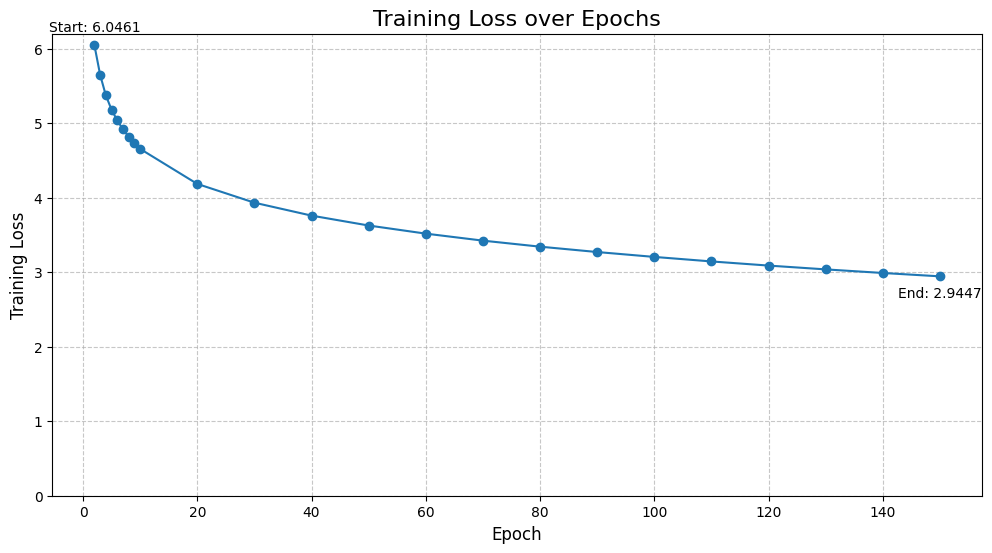

The loss curve has been saved as 'training_loss_curve.png'


In [1]:
import matplotlib.pyplot as plt

# Training loss data
epochs = [2, 3, 4, 5, 6, 7, 8, 9, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150]
losses = [6.0461, 5.6495, 5.3726, 5.1812, 5.0365, 4.9177, 4.8179, 4.7309, 4.6554, 4.1854, 
          3.9332, 3.7598, 3.6269, 3.5180, 3.4239, 3.3430, 3.2710, 3.2054, 3.1448, 3.0891, 
          3.0380, 2.9898, 2.9447]

# Create the plot
plt.figure(figsize=(12, 6))
plt.plot(epochs, losses, marker='o')

# Customize the plot
plt.title('Training Loss over Epochs', fontsize=16)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Training Loss', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)

# Set y-axis to start from 0
plt.ylim(bottom=0)

# Add annotations for start and end points
plt.annotate(f'Start: {losses[0]:.4f}', (epochs[0], losses[0]), textcoords="offset points", xytext=(0,10), ha='center')
plt.annotate(f'End: {losses[-1]:.4f}', (epochs[-1], losses[-1]), textcoords="offset points", xytext=(0,-15), ha='center')

# Save the plot as a PNG file
plt.savefig('training_loss_curve.png', dpi=300, bbox_inches='tight')

# Display the plot (optional, comment out if running on a server without display)
plt.show()

print("The loss curve has been saved as 'training_loss_curve.png'")

In [77]:
import torch
import torch.nn as nn

# Set the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Nucleus (top-p) sampling
def nucleus_sampling(output, p=0.9):
    # Sort the logits in descending order and get corresponding indices
    sorted_logits, sorted_indices = torch.sort(output, descending=True)
    
    # Compute cumulative probabilities
    cumulative_probs = torch.cumsum(torch.softmax(sorted_logits, dim=-1), dim=-1)
    
    # Remove tokens with cumulative probability above the threshold
    sorted_indices_to_remove = cumulative_probs > p
    sorted_indices_to_remove[..., 1:] = sorted_indices_to_remove[..., :-1].clone()
    sorted_indices_to_remove[..., 0] = 0
    
    # Set the logits of the tokens to remove to a large negative value (effectively removing them)
    output[sorted_indices[sorted_indices_to_remove]] = -float("Inf")
    
    # Sample from the filtered distribution
    probabilities = torch.softmax(output, dim=-1)
    next_token = torch.multinomial(probabilities, 1).item()
    
    return next_token

# Penalize repetition to reduce repeated words
def penalize_repetition(output, generated_tokens, penalty=1.5):
    for token in generated_tokens:
        output[token] /= penalty
    return output

# Function to keep generating within the AI topic
def reinforce_topic(text, interval=30):
    topic_phrase = " dating"
    if len(text) > interval:
        text += topic_phrase
    return text

# Text generation function with nucleus sampling and context reinforcement
def generate_text(model, sp, start_text="", max_length=100, temperature=0.7, top_p=0.9, repetition_penalty=1.5, interval=30):
    model.eval()
    tokens = sp.EncodeAsIds(start_text)
    input_seq = torch.tensor(tokens).unsqueeze(0).to(device)
    
    with torch.no_grad():
        for i in range(max_length):
            # Forward pass through the model
            output = model(input_seq)
            output_logits = output[0, -1, :] / temperature
            
            # Apply repetition penalty
            output_logits = penalize_repetition(output_logits, tokens, penalty=repetition_penalty)
            
            # Nucleus sampling (top-p)
            next_token = nucleus_sampling(output_logits, p=top_p)
            
            # Append the next token to the sequence
            tokens.append(next_token)
            input_seq = torch.tensor(tokens).unsqueeze(0).to(device)
            
            # Reinforce the topic periodically
            if i > 0 and i % interval == 0:
                new_text = sp.DecodeIds(tokens)
                new_text = reinforce_topic(new_text, interval)
                tokens = sp.EncodeAsIds(new_text)
                input_seq = torch.tensor(tokens).unsqueeze(0).to(device)
    
    # Decode and return the final generated text
    return sp.DecodeIds(tokens)

# Example of loading the best model
tf_generator.load_state_dict(torch.load('FINAL_model_2.pth'))
tf_generator = tf_generator.to(device)

# Generate text focused on AI
sample_text = generate_text(
    tf_generator, sp, 
    start_text=" Effects of online dating : ", 
    max_length=100, 
    temperature=0.2,   # Lower te4mperature for more structured text
    top_p=0.4,         # Nucleus sampling with top-p
    repetition_penalty=1.5,  # Penalize repetition
    interval=30        # Reinforce the topic every 30 tokens
)

# Print the generated text
print("Generated text:")
print(sample_text)


Generated text:
 Effects of online dating : 2019, the world's largest digital age has opened up new avenues for individuals seeking to connect with their partners. this trend is particularly dating in relation from around a country where users can access vast amounts of information about potential romantic relationships and how they interact within an increasingly popular destination (e dating & sheltera), such as virginia. by examining its features, benefits associated with using social media platforms like tyler or other forms dating sites across multiple websites while fostering engagement through user
